In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn import cluster, manifold
from sklearn.cluster import cluster_optics_dbscan
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.svm import NuSVC
from umap.umap_ import UMAP
from sklearn.pipeline import make_pipeline
import matplotlib.cm as cm
import seaborn as sns

In [5]:
data = pd.read_csv('../data/water_potability.csv')
data.isnull().sum()


ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
data_cleaned = data.dropna()
data_cleaned

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
...,...,...,...,...,...,...,...,...,...,...
3267,8.989900,215.047358,15921.412018,6.297312,312.931022,390.410231,9.899115,55.069304,4.613843,1
3268,6.702547,207.321086,17246.920347,7.708117,304.510230,329.266002,16.217303,28.878601,3.442983,1
3269,11.491011,94.812545,37188.826022,9.263166,258.930600,439.893618,16.172755,41.558501,4.369264,1
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712,1


In [7]:
Y = data_cleaned['Potability']
X = data_cleaned.drop(columns=['Potability'])

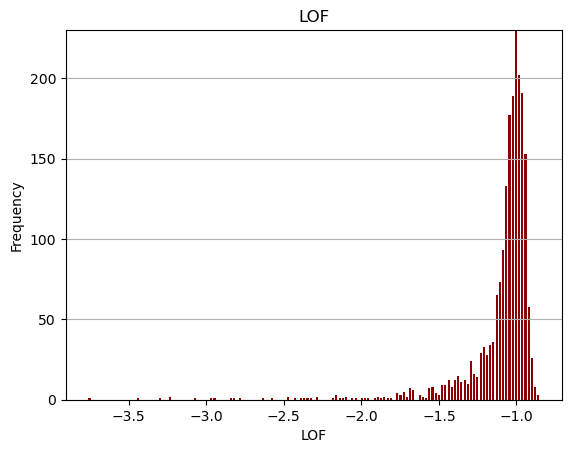

In [8]:
data_minmax = MinMaxScaler().fit_transform(X.values)
pca = PCA(0.95, whiten=True)
data_pca = pca.fit_transform(X.values) 
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean')
lof.fit_predict(data_pca)
scores = lof.negative_outlier_factor_
def plot_hist(X: pd.DataFrame, title: str) -> None:
    """ Funcion que genera un grafico de los valores de LOF del dataset """
    x, bins, patches = plt.hist(x=X, bins='auto', rwidth=0.65, color='darkred')
    plt.grid(axis='y')
    plt.xlabel('LOF')
    plt.ylabel('Frequency')
    plt.title(title)
    maxfreq = x.max()
    plt.ylim(ymax=np.ceil(maxfreq))
    
plot_hist(scores, 'LOF')

In [9]:
# Dado el grafico anterior, diremos que un umbral de corte sera aproximadamente -1.85
def lof_threshold(v: float, scores: np.ndarray) -> float:
    ''' Retorna la contaminacion del medio '''
    N = len(scores)
    points = scores[scores < v]
    threshold = len(points)/N
    return threshold 

lof_threshold(-2.25, scores) # Contaminacion del medio


0.01093983092988563

In [10]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean', contamination=0.01093983092988563)
labels = lof.fit_predict(X.values)
indices = list(np.where(labels==1)[0])
X = X.iloc[indices]
Y = Y.iloc[indices]
print(X.shape, Y.shape)

(1989, 9) (1989,)


In [11]:
X_scaled = MinMaxScaler().fit_transform(X.values)

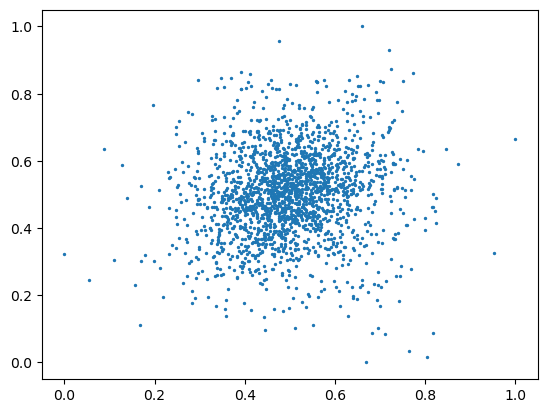

In [12]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=2)
plt.show()

In [13]:
KERNELS = ['linear', 'poly', 'rbf', 'sigmoid'] 
DEGREES = [2, 3, 4, 5, 6] 
RANGE_NU = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, stratify=Y)

In [22]:
for kernel_ in KERNELS:
    if kernel_ == 'poly':
        for degree_ in DEGREES:
            for nu_ in RANGE_NU:
                clf = make_pipeline(StandardScaler(), NuSVC(kernel=kernel_, degree= degree_, nu=nu_))
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                print(
                    "For kernel =",
                    kernel_,
                    "with degree =",
                    degree_,
                    "with nu value = ",
                    nu_,
                    "The accuracy is :",
                    acc,
                )
    else:
        for nu_ in RANGE_NU:
            clf = make_pipeline(StandardScaler(), NuSVC(kernel=kernel_, nu=nu_))
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            print(
                "For kernel =",
                kernel_,
                "With nu value = ",
                nu_,
                "The accuracy is :",
                acc,
            )

For kernel = linear With nu value =  0.05 The accuracy is : 0.4824120603015075
For kernel = linear With nu value =  0.1 The accuracy is : 0.5494137353433836
For kernel = linear With nu value =  0.2 The accuracy is : 0.45058626465661644
For kernel = linear With nu value =  0.3 The accuracy is : 0.48743718592964824
For kernel = linear With nu value =  0.4 The accuracy is : 0.5041876046901173
For kernel = linear With nu value =  0.5 The accuracy is : 0.4639865996649916
For kernel = linear With nu value =  0.6 The accuracy is : 0.5360134003350083
For kernel = linear With nu value =  0.7 The accuracy is : 0.490787269681742
For kernel = poly with degree = 2 with nu value =  0.05 The accuracy is : 0.49748743718592964
For kernel = poly with degree = 2 with nu value =  0.1 The accuracy is : 0.5058626465661642
For kernel = poly with degree = 2 with nu value =  0.2 The accuracy is : 0.4154103852596315
For kernel = poly with degree = 2 with nu value =  0.3 The accuracy is : 0.5561139028475712
For 

For kernel = rbf With nu value =  0.7 The accuracy is : 0.711892797319933


In [23]:
clf = make_pipeline(StandardScaler(), NuSVC(kernel='rbf', nu=0.7))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.90      0.79       357
           1       0.75      0.42      0.54       240

    accuracy                           0.71       597
   macro avg       0.73      0.66      0.67       597
weighted avg       0.72      0.71      0.69       597



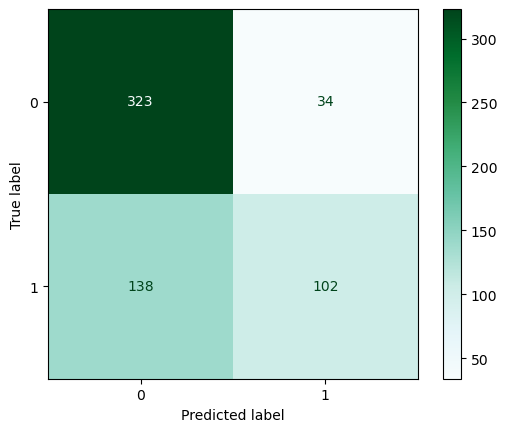

In [24]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='BuGn')